In [3]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190606

In [4]:
import os
import pytz
import datetime as dt
import numpy as np
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [6]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190606 (07 broken!)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190606


In [7]:
import cs230_project_utilities as utils

In [8]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

In [9]:
def localized_timestamp():
    return dt.datetime.now(tz=pytz.timezone('America/Los_Angeles')).strftime("%Y-%m-%d_%H:%M:%S")

In [10]:
# Predict on a test batch

def predict_and_visualize(model, x, y):

    # Run model
    y_pred = model.predict(x)

    # Inspect output
    for i in range(len(x)):

        fft = utils.fastmri._combine_two_channels_of_complex_tensor(x[i]).numpy()
        fft_mag = np.abs(fft)
        fft_ang = np.angle(fft)
        reconstruction = y_pred[i, ..., 0]
        image = y[i, ..., 0]

        MSE = utils.signal_processing.mean_square_error(reconstruction, image)
        PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

        plt.subplot(2, 2, 1)
        plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
        utils.plot.imshowgray(reconstruction)

        plt.subplot(2, 2, 2)
        plt.title('FFT (Magnitude)')
        utils.plot.imshowfft(fft_mag)

        plt.subplot(2, 2, 3)
        plt.title('Expected reconstruction')
        utils.plot.imshowgray(image)

        plt.subplot(2, 2, 4)
        plt.title('FFT (Phase)')
        utils.plot.imshowgray(fft_ang)

        plt.show()
        break
        
    print('For validation: x.sum()={}, y.sum()={}, y_pred.sum()={}'.format(x.sum(), y.sum(), y_pred.sum()))
    print('Model iterations: {}'.format(model.optimizer.iterations.numpy()))
        
    # Return model output
    return y_pred

# Load a saved model

def restore_model(restore_path, weights_only, model=None, custom_objects=None):
    '''
    Restoring saved models
    
    - To restore a `tf.keras.Model` saved with `model.save_weights(...)`:
        Set `weights_only` to `True`. Restore weights at `restore_path` into `model`.
    - To restore a `tf.keras.Model` saved with `model.save(...)`:
        Set `weights_only` to `False`. Load and return and entire model at `restore_path`,
        optionally passing in the dictionary `custom_objects`.
    '''
    if weights_only:
        assert model is not None, 'Must pass a model if only restoring weights.'
        model.load_weights(restore_path)
    else:
        assert model is None, 'Do not pass a model if only restoring weights. A model will be returned.'
        model = tf.keras.models.load_model(restore_path, custom_objects=custom_objects)

    return model



# Load dataset as TFRecords 

In [11]:
# Sync from remote storage in s3
# aws s3 sync s3://cs230-automap/data/fastmri/tfrecords cs230/data/fastmri/tfrecords

In [12]:
dev_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_dev/*.tfrecord'
test_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'
train_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_train/*.tfrecord'

In [13]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

batch_size = 32

dev_dataset = utils.fastmri.load_dataset(dev_locations,
                                         batch_size=8,
                                         shuffle_buffer_size=384,
                                         load_original_reconstruction=False,
                                         include_all_parsed_features=False,
                                         ignore_errors=True,
                                         data_augmentation='symmetric')

test_dataset = utils.fastmri.load_dataset(test_locations,
                                          batch_size=8,
                                          shuffle_buffer_size=384,
                                          load_original_reconstruction=False,
                                          include_all_parsed_features=False,
                                          ignore_errors=True,
#                                           data_augmentation=None)
                                         data_augmentation='symmetric')

train_dataset = utils.fastmri.load_dataset(train_locations,
                                           batch_size=batch_size,
                                           shuffle_buffer_size=1024,
                                           load_original_reconstruction=False,
                                           include_all_parsed_features=False,
                                           ignore_errors=True,
                                           data_augmentation='symmetric')

Loading dataset... Shuffle items? True. Shuffle buffer: 384
Loading dataset... Shuffle items? True. Shuffle buffer: 384
Loading dataset... Shuffle items? True. Shuffle buffer: 1024


# Validate dataset
Make sure target reconstruction is the same as reconstruction computed from input.

In [14]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

In [15]:
def first_batches():
    batches = [(first_test_batch, 'Test'), (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    return batches

In [16]:
first_test_batch[0].shape

TensorShape([8, 128, 128, 2])

In [17]:
fft, target_image = first_test_batch[0][-1].numpy().squeeze(), first_test_batch[1][-1].numpy().squeeze()
fft = utils.fastmri._combine_two_channels_of_complex_tensor(fft).numpy()

# Compute image from input `fft`
image_from_fft = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

# Compare target image to reconstruction from input `fft`
np.allclose(image_from_fft, target_image, atol=1e-6), utils.signal_processing.mean_square_error(image_from_fft, target_image)

(True, 1.1212241e-14)

In [18]:
# Should be in [0, 1]
image_from_fft.min(), image_from_fft.max(), target_image.min(), target_image.max()

(0.0057508647, 0.9999995, 0.0057506193, 1.0)

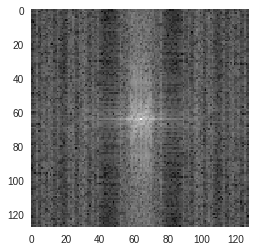

In [19]:
utils.plot.imshowfft(fft)

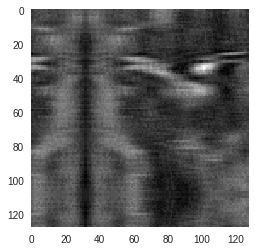

In [20]:
utils.plot.imshowgray(target_image)

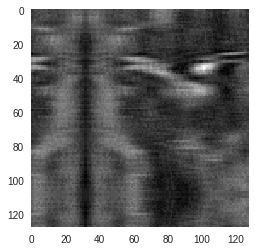

In [21]:
utils.plot.imshowgray(image_from_fft)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


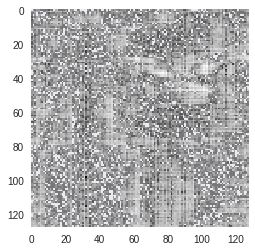

In [22]:
utils.plot.imshowfft(np.square(target_image - image_from_fft))

# Model

In [23]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [24]:
# Model most similar to OG AUTOMAP
# def load_uncompiled_automap_model():

#     N = 128
#     X = tf.keras.layers.Input(shape=(N, N, 2))

#     # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
#     # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
#     # noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
#     # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

#     ds_flat = tf.keras.layers.Flatten()(X)

# #     fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
# #     fc1 = tf.keras.layers.Dropout(0.05)(fc1)
#     fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(ds_flat)

#     fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

#     conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
#     # L1 regularization to encourage sparsity
#     conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
#                                    activity_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [25]:
# def load_uncompiled_automap_model():
    
#     # this one's solid, but I believe we'll need a few hours to train it.
    
#     N = 128
#     F = 32
#     X = tf.keras.layers.Input(shape=(N, N, 2))

# #     Half-assed data augmentation
# #     noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (N, N, 2)

#     # These layers all halve the spatial dimension (but also each output F channels)
#     conv1 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(X)])
#     pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # spatial dim: N / 2
    
#     conv2 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool1)])
#     pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # spatial dim: N / 4
    
#     conv3 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool2)])
#     pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # spatial dim: N / 8
    
#     conv4 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(pool3)])
#     # spatial dim: N / 4
    
#     conv5 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv4)])
#     # spatial dim: N / 2
    
#     conv6 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv5)])
#     # spatial dim: N
    
#     conv7 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(conv6)])
    
#     t_conv8 = tf.keras.layers.Conv2DTranspose(6 * F, 5, strides=1, activation='relu', padding='same',
#                                               # Encourage sparsity in output (MRI images are mostly zeros)
#                                               activity_regularizer=tf.keras.regularizers.l1(1e-6))(conv7)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv8) # spatial dim: 128

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [26]:
def load_uncompiled_automap_model():
    
    # this one's solid, but I believe we'll need a few hours to train it.
    
    N = 128
    F = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Half-assed data augmentation
    noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (256, 256, 256)

    # These layers all halve the spatial dimension (but also each output 256 channels)
    conv1 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(X)
    pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # shape: (128, 128, F)

    conv2 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # shape: (64, 64, F)

    conv3 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool2)
    pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # shape: (32, 32, F)

    conv4 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool3)
    pool4 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv4) # shape: (16, 16, F)

    conv5 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool4)
    pool5 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv5) # shape: (8, 8, F)

    # A "FC-like" layer for fun before we do upsampling
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(pool5) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(4 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4

    # These transposed convolutions upsample spatial dimension by 2
    t_conv1 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv7) # spatial dim: 8
    t_conv2 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv1) # spatial dim: 16
    t_conv3 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv2) # spatial dim: 32
    t_conv4 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv3) # spatial dim: 64
    t_conv5 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv4) # spatial dim: 128
    
    t_conv6 = tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same',
                                              # Encourage sparsity in output (MRI images are mostly zeros)
                                              activity_regularizer=tf.keras.regularizers.l1(1e-6))(t_conv5)
    
    Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv6) # spatial dim: 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [27]:
def lr_schedule(epoch):
    initial_lr = 2e-4
    if epoch < 20:
        return 2e-4
    elif epoch >= 20 and epoch < 120:
        return 1e-4
    elif epoch >= 120 and epoch < 150:
        return 1e-5
    elif epoch >= 150 and epoch < 170:
        return 5e-5
    elif epoch >= 170 and epoch < 200:
        return 1e-5
    elif epoch >= 200 and epoch < 220:
        return 1e-6
    elif epoch >= 220 and epoch < 250:
        return 5e-6
    elif epoch >= 250 and epoch < 270:
        return 1e-6
    else:
        return 1e-7

In [28]:
def load_compiled_automap_model():
    multi_gpu = False
    if multi_gpu:
        # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
        # mirrored strategy). Restricts callbacks we can use
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            optimizer = tf.keras.optimizers.Adam()
            model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    return model

In [29]:
# Uncomment to train a new model
model = load_compiled_automap_model()
initial_epoch = 0

In [30]:
def epoch_from_model_path(path):
    # Used to resume training.
    # Example:
    # Returns 150 if `path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'.

    epoch_string = os.path.basename(path)[3:7]
    epoch = int(epoch_string)
    return epoch

In [31]:
# # Uncomment to restore a model and resume training
# saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0165.ckpt'
# model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
# initial_epoch = epoch_from_model_path(saved_model_path)
# print('Restored model with {} completed epochs'.format(initial_epoch))
# model.evaluate(test_dataset)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     2432      
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 128)       0     

# Training

In [33]:
# Show reconstructions during training

def plot_fft_reconstructions(epoch, logs):
    for dataset_batch, name in first_batches():
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 10)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=epoch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=epoch)

In [34]:
# Show activation histograms

def layer_activations(inputs):
    layers = model.layers
    names = [l.name for l in layers]
    input_tensor = layers[0].input
    outputs = [l.output for l in layers]
    
    get_activations = tf.keras.backend.function(input_tensor, outputs)
    activations = get_activations(inputs=inputs)
    
    return list(zip(names, activations))

def plot_activations(epoch, logs):
    with file_writer.as_default():
        for dataset_batch, stage in first_batches():
            for layer_name, layer_activation in layer_activations(dataset_batch):
                tf.summary.histogram('{}/activations/{}'.format(layer_name, stage.lower()), layer_activation,
                                    step=epoch)


In [35]:
# Clear logs and models if necessary
# !rm -r /home/ubuntu/cs230/logs/
# !rm -r /home/ubuntu/cs230/models

In [36]:
# Save current timestamp (we'll use it in our paths to model and log directories)

current_timestamp = localized_timestamp() # get new value if training new model
print('Using current timestamp: {}'.format(current_timestamp))

# current_timestamp = '2019-06-07_00:49:20' # use previous value if resuming training

Using current timestamp: 2019-06-08_02:39:50


In [37]:
# Define where logs will be saved

logdir = os.path.join('/home/ubuntu/cs230/logs', current_timestamp)
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [38]:
# Callback for printing the LR at the end of each epoch.

class LearningRateLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            current_lr = model.optimizer.lr.numpy()
            tf.summary.scalar('learning rate', data=current_lr, step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, current_lr))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_fft_reconstructions)

plot_activations_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_activations)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq='epoch',
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

set_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

# Callback for checkpointing model

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = os.path.join('/home/ubuntu/cs230/models/automap_fastmri',
                               current_timestamp,
                               'cp-{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False,
    # Save every K-batches (or samples?)
    save_freq=500_000)

completed_training_steps = model.optimizer.iterations.numpy()

if completed_training_steps == 0:
    # Only do this if not resuming training (don't want to overwrite anything, but also unnecessary
    # to prompt user by setting `overwrite=False`).
    model_save_path = checkpoint_path.format(epoch=0)
    model_save_dir = os.path.dirname(model_save_path)
    os.makedirs(model_save_dir, exist_ok=True)
    model.save(model_save_path)
elif completed_training_steps > 0:
    tensorboard_callback._samples_seen = completed_training_steps * batch_size
    tensorboard_callback._total_batches_seen = completed_training_steps

callbacks = [tensorboard_callback, plot_images_callback, plot_activations_callback,
             set_lr_callback, reduce_lr_callback, LearningRateLoggingCallback()]#, checkpoint_callback]

### Begin training and open Tensorboard to monitor

In [ ]:
num_epochs = 300 # if resuming training, this still has to be higher than greatest checkpoint

training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=num_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/300
   1085/Unknown - 121s 112ms/step - loss: 0.0335 - mean_PSNR: 15.7107
Learning rate for epoch 1 is 0.00019999999494757503
1085/1085 [==============================] - 141s 130ms/step - loss: 0.0335 - mean_PSNR: 15.7107 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0283 - mean_PSNR: 16.2934
Learning rate for epoch 2 is 0.00019999999494757503
1085/1085 [==============================] - 133s 123ms/step - loss: 0.0283 - mean_PSNR: 16.2936 - val_loss: 0.0232 - val_mean_PSNR: 17.1343
Epoch 3/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0204 - mean_PSNR: 17.6792
Learning rate for epoch 3 is 0.00019999999494757503
1085/1085 [==============================] - 134s 123ms/step - loss: 0.0204 - mean_PSNR: 17.6791 - val_loss: 0.0193 - val_mean_PSNR: 17.8968
Epoch 4/300
  34/1085 [..............................] - ETA: 1:52 - loss: 0.0197 - mean_PSNR: 17.7412

### Save model (in case isn't saved after final epoch)

In [ ]:
# Uncomment to save model
model_save_path = checkpoint_path.format(epoch=num_epochs)
model.save(model_save_path)
print('Saved model to: {}'.format(model_save_path))

## Evaluate model

In [ ]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

### Plot training history (but better viewed in Tensorboard)

In [ ]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

In [ ]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

In [ ]:
plt.figure()
plt.plot(training_history.history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')

In [ ]:
# Predict on a test batch

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
predict_and_visualize(model, x, y);

# Restore and run saved model

In [ ]:
saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'
restored_model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
predict_and_visualize(restored_model, x, y);

In [ ]:
restored_model.evaluate(test_dataset, verbose=1)